In [ ]:
# Muhammad Fauzan Nur'ilham
# 1103204085
# Machine Learning
# TK-44-G4

In [ ]:
# Import library PyTorch untuk deep learning
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

# Import library-transformasi dan dataset dari torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets

# Import beberapa modul dari scikit-learn untuk analisis dan visualisasi data
from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# Import modul tqdm untuk menampilkan progress bar saat iterasi
from tqdm.notebook import tqdm, trange

# Import matplotlib untuk visualisasi data
import matplotlib.pyplot as plt

# Import NumPy untuk operasi numerik
import numpy as np

# Import modul copy untuk menyalin objek
import copy

# Import modul random untuk menghasilkan nilai acak
import random

# Import modul time untuk pengukuran waktu eksekusi
import time

In [ ]:
# Menetapkan nilai seed (bilangan acak awal) untuk mengontrol reproduktibilitas
SEED = 1234

# Menetapkan seed untuk modul random dalam Python
random.seed(SEED)

# Menetapkan seed untuk modul numpy
np.random.seed(SEED)

# Menetapkan seed untuk modul torch dalam PyTorch (untuk operasi pada CPU)
torch.manual_seed(SEED)

# Menetapkan seed untuk modul torch CUDA dalam PyTorch (untuk operasi pada GPU)
torch.cuda.manual_seed(SEED)

# Menetapkan seed untuk backend cudnn dalam PyTorch agar hasilnya dapat direproduksi (opsional)
torch.backends.cudnn.deterministic = True

In [ ]:
# Menetapkan direktori root untuk menyimpan data
ROOT = '.data'

# Mengunduh dataset MNIST dan menyimpannya dalam direktori ROOT
train_data = datasets.MNIST(root=ROOT, train=True, download=True)

# Menghitung rata-rata dan standar deviasi dari data pelatihan MNIST
mean = train_data.data.float().mean() / 255
std = train_data.data.float().std() / 255

# Menampilkan hasil perhitungan
print(f'Calculated mean: {mean}')
print(f'Calculated std: {std}')

100%|██████████| 9912422/9912422 [00:00<00:00, 96967779.60it/s]


Extracting .data/MNIST/raw/train-images-idx3-ubyte.gz to .data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 43605361.35it/s]


Extracting .data/MNIST/raw/train-labels-idx1-ubyte.gz to .data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 31931976.79it/s]


Extracting .data/MNIST/raw/t10k-images-idx3-ubyte.gz to .data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 6724507.15it/s]


Extracting .data/MNIST/raw/t10k-labels-idx1-ubyte.gz to .data/MNIST/raw

Calculated mean: 0.13066047430038452
Calculated std: 0.30810779333114624


In [ ]:
# Membuat objek transforms.Compose yang akan menggabungkan beberapa transformasi.
train_transforms = transforms.Compose([
                            # Melakukan rotasi acak sebanyak 5 derajat pada gambar, dengan mengisi piksel kosong dengan nilai 0.
                            transforms.RandomRotation(5, fill=(0,)),
                            # Melakukan pemangkasan acak pada gambar dengan ukuran 28x28 dan padding sebesar 2 piksel.
                            transforms.RandomCrop(28, padding=2),
                            # Mengonversi gambar menjadi tensor.
                            transforms.ToTensor(),
                            # Melakukan normalisasi gambar dengan mengurangkan nilai mean dan membagi dengan nilai std.
                            transforms.Normalize(mean=[mean], std=[std])
                                      ])

# Membuat objek transforms.Compose yang akan menggabungkan beberapa transformasi.
test_transforms = transforms.Compose([
                           # Mengonversi gambar menjadi tensor.
                           transforms.ToTensor(),
                           # Melakukan normalisasi gambar dengan mengurangkan nilai mean dan membagi dengan nilai std.
                           transforms.Normalize(mean=[mean], std=[std])
                                     ])

In [ ]:
# Membuat objek datasets.MNIST untuk data latih dengan konfigurasi root folder, mode train, download jika belum ada, dan menggunakan transformasi train_transforms.
train_data = datasets.MNIST(root=ROOT,
                            train=True,
                            download=True,
                            transform=train_transforms)

# Membuat objek datasets.MNIST untuk data uji dengan konfigurasi root folder, mode test, download jika belum ada, dan menggunakan transformasi test_transforms.
test_data = datasets.MNIST(root=ROOT,
                           train=False,
                           download=True,
                           transform=test_transforms)

In [ ]:
# Proporsi data validasi terhadap total data latih.
VALID_RATIO = 0.9

# Jumlah contoh data latih yang akan digunakan.
n_train_examples = int(len(train_data) * VALID_RATIO)
# Jumlah contoh data validasi yang akan digunakan.
n_valid_examples = len(train_data) - n_train_examples

# Memecah dataset data latih menjadi dua bagian: data latih dan data validasi.
train_data, valid_data = data.random_split(train_data,
                                           [n_train_examples, n_valid_examples])

In [ ]:
# Melakukan deep copy pada objek valid_data.
valid_data = copy.deepcopy(valid_data)
# Mengganti transformasi data validasi dengan transformasi test_transforms.
valid_data.dataset.transform = test_transforms

In [ ]:
# Menampilkan jumlah contoh data latih.
print(f'Number of training examples: {len(train_data)}')
# Menampilkan jumlah contoh data validasi.
print(f'Number of validation examples: {len(valid_data)}')
# Menampilkan jumlah contoh data uji.
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 54000
Number of validation examples: 6000
Number of testing examples: 10000


In [ ]:
# Menentukan ukuran batch yang akan digunakan selama pelatihan, validasi, dan pengujian.
BATCH_SIZE = 64

# Membuat iterator untuk data latih dengan konfigurasi shuffle (acak) dan ukuran batch sesuai dengan BATCH_SIZE.
train_iterator = data.DataLoader(train_data,
                                 shuffle=True,
                                 batch_size=BATCH_SIZE)

# Membuat iterator untuk data validasi dengan ukuran batch sesuai dengan BATCH_SIZE.
valid_iterator = data.DataLoader(valid_data,
                                 batch_size=BATCH_SIZE)

# Membuat iterator untuk data uji dengan ukuran batch sesuai dengan BATCH_SIZE.
test_iterator = data.DataLoader(test_data,
                                batch_size=BATCH_SIZE)

In [ ]:
def plot_filter(images, filter):

    # Menggabungkan beberapa gambar menjadi satu tensor.
    images = torch.cat([i.unsqueeze(0) for i in images],
                                dim=0).cpu()
    # Mengubah filter menjadi tensor dan menambahkan dimensi untuk batch dan saluran.
    filter = torch.FloatTensor(filter).unsqueeze(0).unsqueeze(0).cpu()

    # Mendapatkan jumlah gambar.
    n_images = images.shape[0]

    # Melakukan operasi konvolusi pada gambar dengan filter.
    filtered_images = F.conv2d(images, filter)

    # Membuat objek figure (gambar) dengan ukuran tertentu.
    fig = plt.figure(figsize=(20, 5))

    for i in range(n_images):

        # Menambahkan subplot untuk gambar asli.
        ax = fig.add_subplot(2, n_images, i+1)
        ax.imshow(images[i].squeeze(0), cmap='bone')
        ax.set_title('Original')
        ax.axis('off')

        # Menambahkan subplot untuk gambar yang telah difilter.
        image = filtered_images[i].squeeze(0)

        ax = fig.add_subplot(2, n_images, n_images+i+1)
        ax.imshow(image, cmap='bone')
        ax.set_title('Filtered')
        ax.axis('off')

In [ ]:
# Jumlah gambar yang akan diambil dari data uji.
N_IMAGES = 5

# Mengambil N_IMAGES gambar beserta labelnya dari data uji menggunakan list comprehension.
images = [image for image, label in [test_data[i] for i in range(N_IMAGES)]]

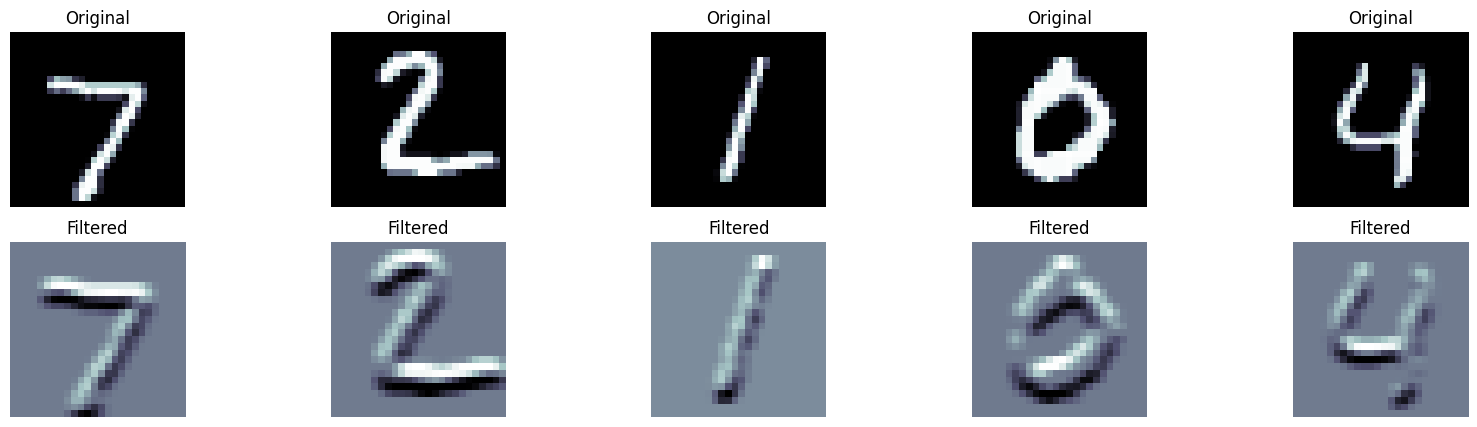

In [ ]:
# Matriks filter untuk operasi konvolusi horizontal.
horizontal_filter = [[-1, -2, -1],
                     [ 0,  0,  0],
                     [ 1,  2,  1]]

# Menampilkan gambar-gambar dari data uji yang telah difilter dengan matriks filter horizontal.
plot_filter(images, horizontal_filter)

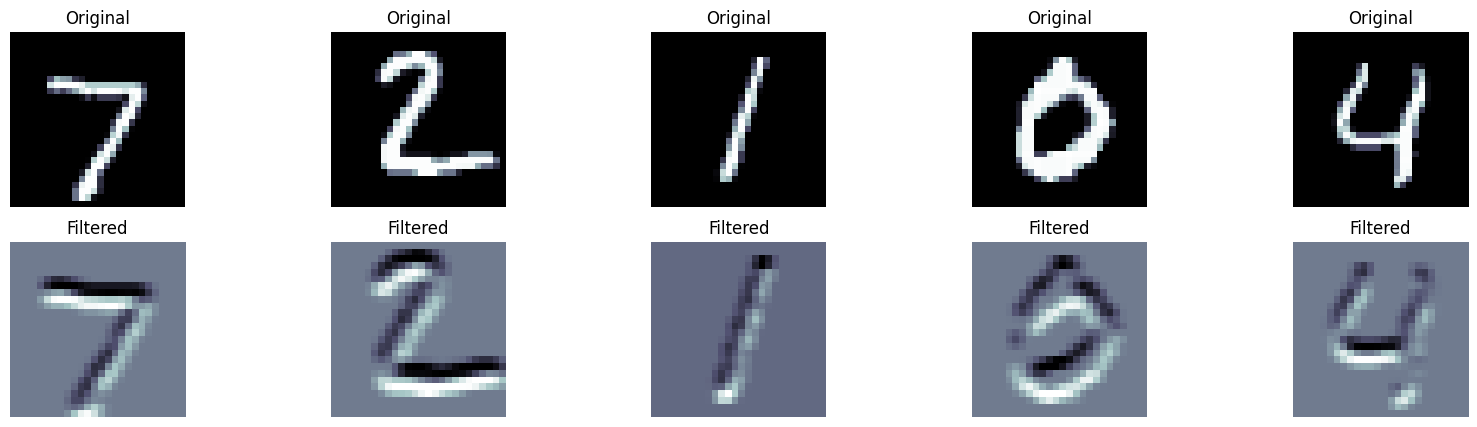

In [ ]:
horizontal_filter = [[ 1,  2,  1],
                     [ 0,  0,  0],
                     [-1, -2, -1]]

plot_filter(images, horizontal_filter)

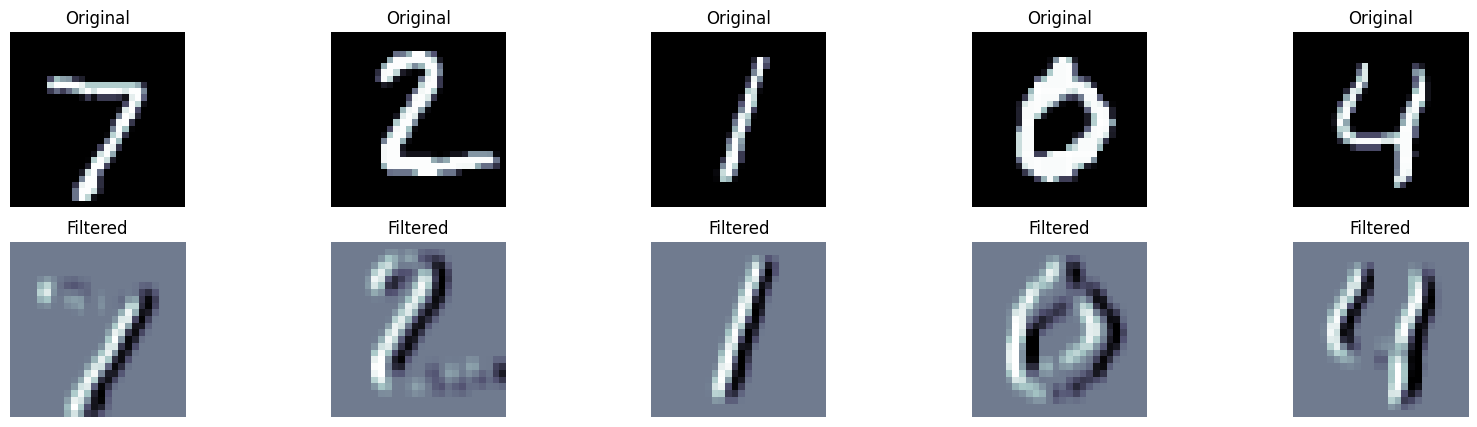

In [ ]:
vertical_filter = [[-1, 0, 1],
                   [-2, 0, 2],
                   [-1, 0, 1]]

plot_filter(images, vertical_filter)

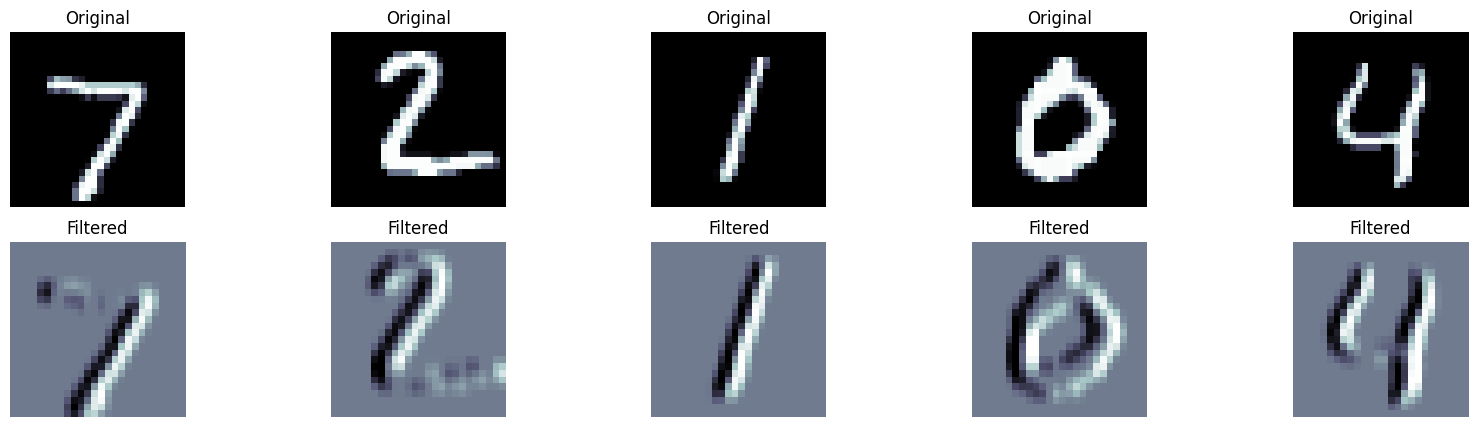

In [ ]:
vertical_filter = [[1, 0, -1],
                   [2, 0, -2],
                   [1, 0, -1]]

plot_filter(images, vertical_filter)

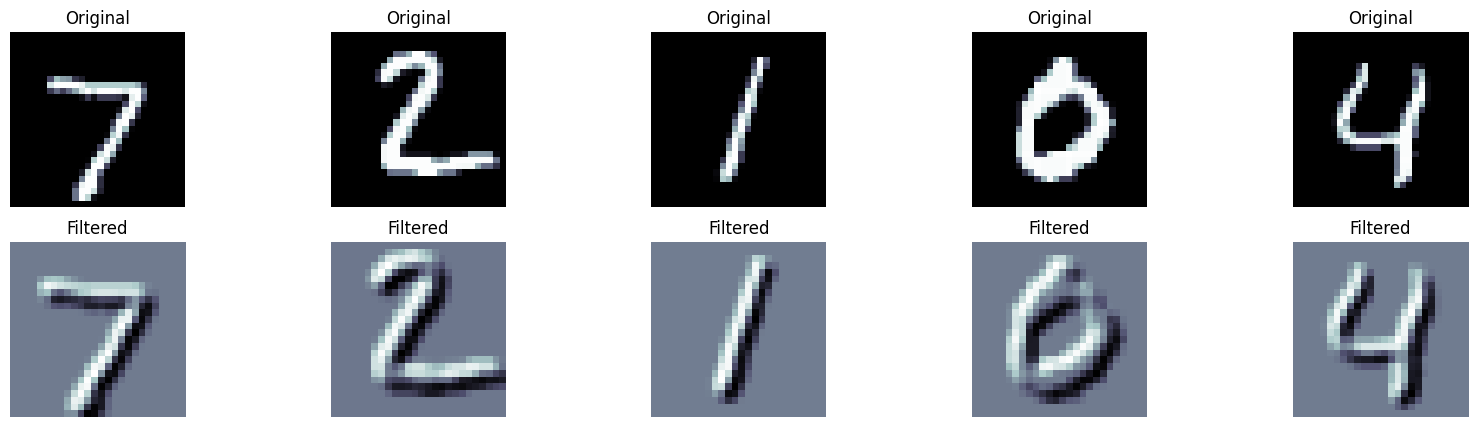

In [ ]:
diagonal_filter = [[-2, -1, 0],
                   [-1,  0, 1],
                   [ 0,  1, 2]]

plot_filter(images, diagonal_filter)

In [ ]:
# Fungsi untuk menampilkan gambar yang telah disubsample dengan metode pooling.
def plot_subsample(images, pool_type, pool_size):

    # Menggabungkan beberapa gambar menjadi satu tensor.
    images = torch.cat([i.unsqueeze(0) for i in images], dim=0).cpu()

    # Menentukan jenis pooling berdasarkan nilai pool_type.
    if pool_type.lower() == 'max':
        pool = F.max_pool2d
    elif pool_type.lower() in ['mean', 'avg']:
        pool = F.avg_pool2d
    else:
        raise ValueError(f'pool_type must be either max or mean, got: {pool_type}')

    # Mendapatkan jumlah gambar.
    n_images = images.shape[0]

    # Melakukan operasi pooling pada gambar.
    pooled_images = pool(images, kernel_size=pool_size)

    # Membuat objek figure (gambar) dengan ukuran tertentu.
    fig = plt.figure(figsize=(20, 5))

    # Loop untuk setiap gambar dalam batch.
    for i in range(n_images):

        # Menambahkan subplot untuk gambar asli.
        ax = fig.add_subplot(2, n_images, i+1)
        ax.imshow(images[i].squeeze(0), cmap='bone')
        ax.set_title('Original')
        ax.axis('off')

        # Menambahkan subplot untuk gambar yang telah disubsample.
        image = pooled_images[i].squeeze(0)

        ax = fig.add_subplot(2, n_images, n_images+i+1)
        ax.imshow(image, cmap='bone')
        ax.set_title('Subsampled')
        ax.axis('off')

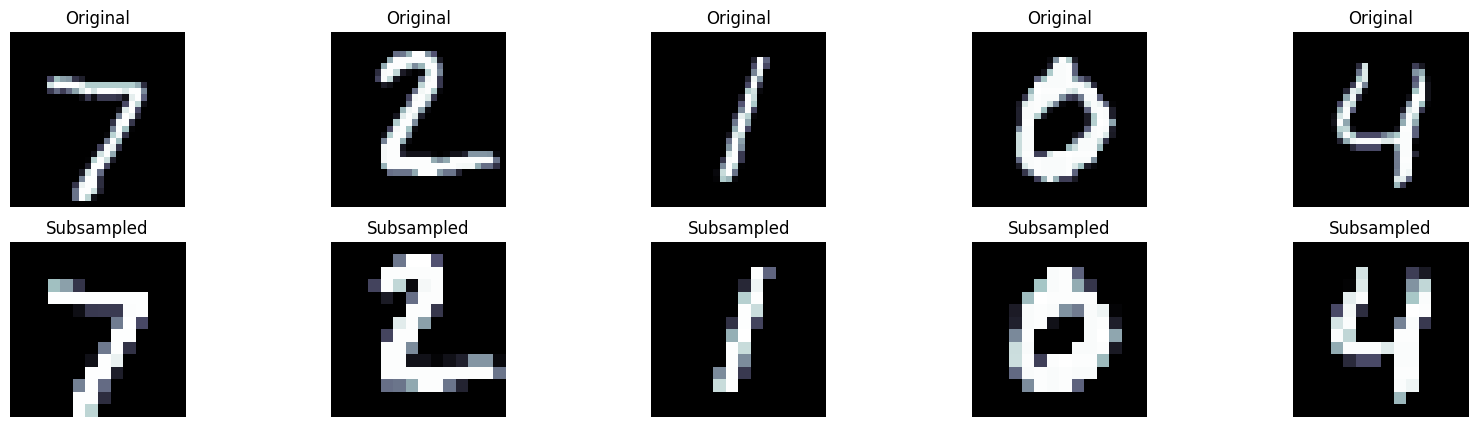

In [ ]:
plot_subsample(images, 'max', 2)

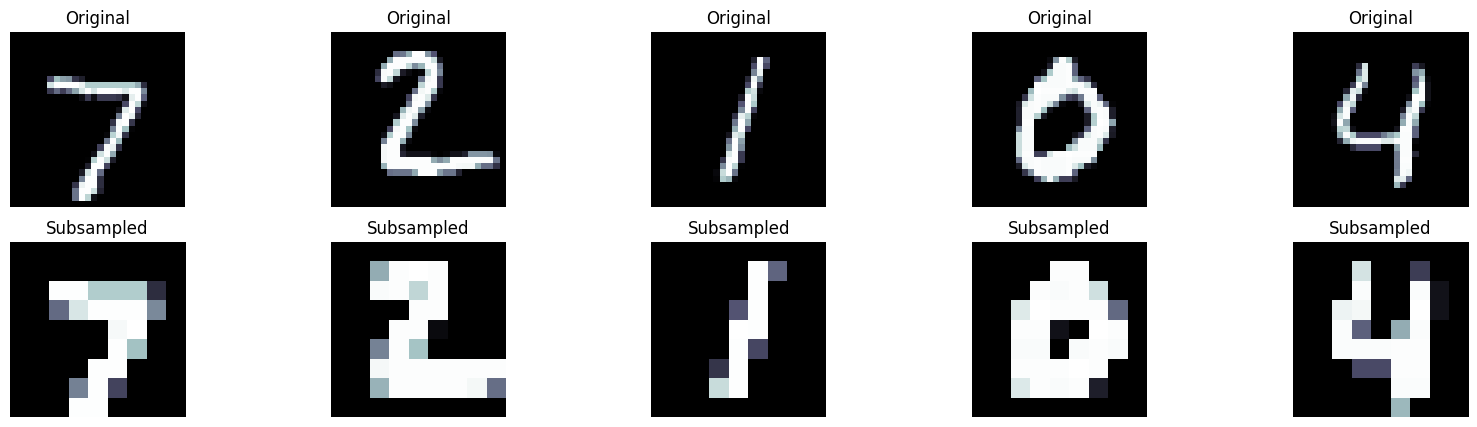

In [ ]:
plot_subsample(images, 'max', 3)

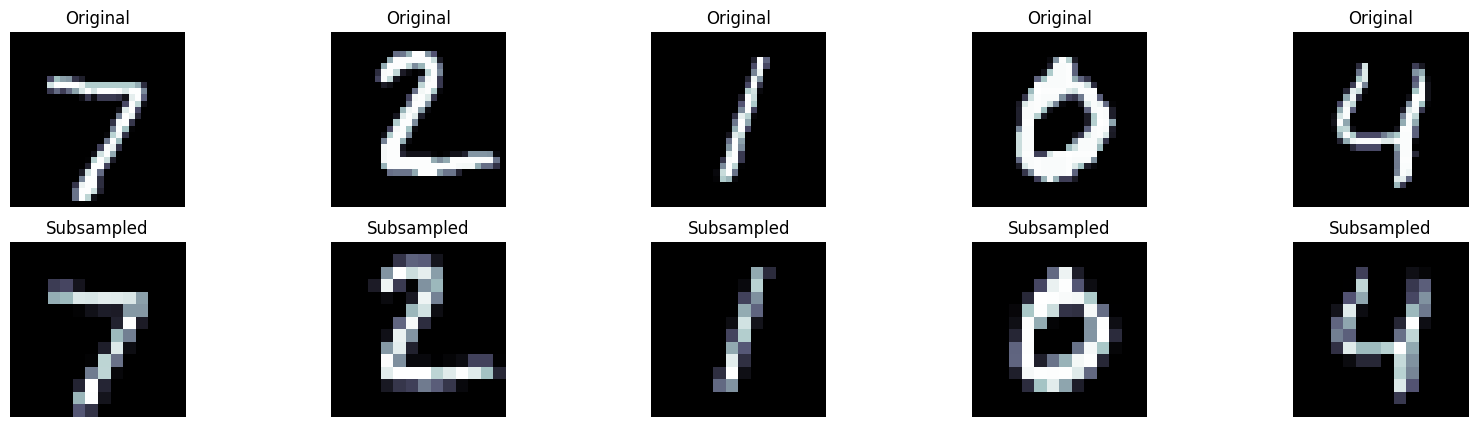

In [ ]:
plot_subsample(images, 'avg', 2)

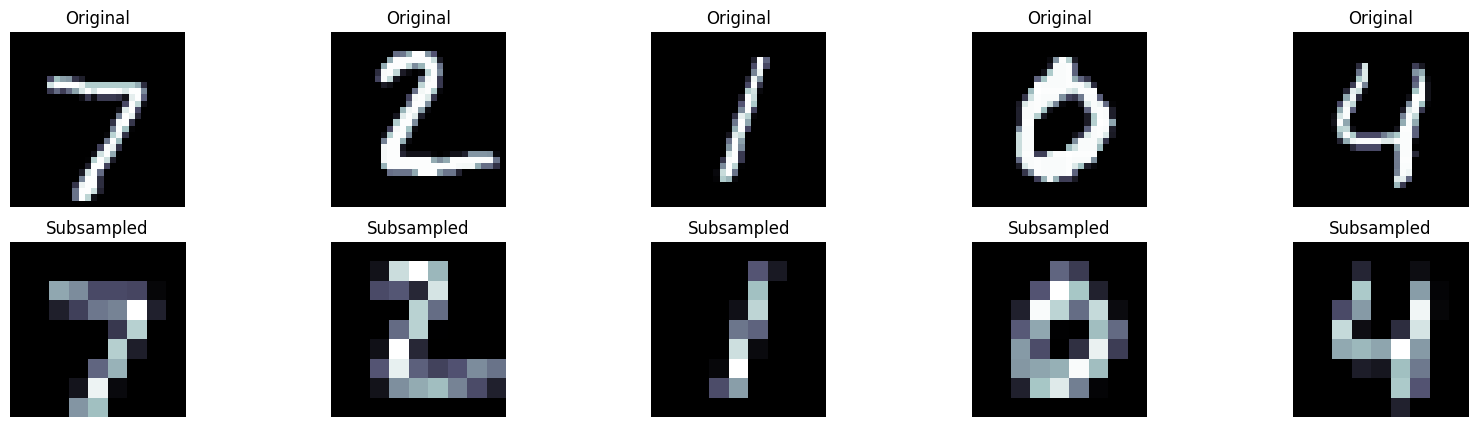

In [ ]:
plot_subsample(images, 'avg', 3)

In [ ]:
# Definisi kelas LeNet untuk arsitektur jaringan saraf tiruan (CNN).
class LeNet(nn.Module):
    def __init__(self, output_dim):
        super().__init__()

        # Layer konvolusi pertama.
        self.conv1 = nn.Conv2d(in_channels=1,
                               out_channels=6,
                               kernel_size=5)

        # Layer konvolusi kedua.
        self.conv2 = nn.Conv2d(in_channels=6,
                               out_channels=16,
                               kernel_size=5)

        # Fully connected layer 1.
        self.fc_1 = nn.Linear(16 * 4 * 4, 120)

        # Fully connected layer 2.
        self.fc_2 = nn.Linear(120, 84)

        # Fully connected layer 3 (output layer).
        self.fc_3 = nn.Linear(84, output_dim)

    def forward(self, x):

        # x = [batch size, 1, 28, 28]

        x = self.conv1(x)

        # x = [batch size, 6, 24, 24]

        x = F.max_pool2d(x, kernel_size=2)

        # x = [batch size, 6, 12, 12]

        x = F.relu(x)

        x = self.conv2(x)

        # x = [batch size, 16, 8, 8]

        x = F.max_pool2d(x, kernel_size=2)

        # x = [batch size, 16, 4, 4]

        x = F.relu(x)

        x = x.view(x.shape[0], -1)

        # x = [batch size, 16*4*4 = 256]

        h = x

        x = self.fc_1(x)

        # x = [batch size, 120]

        x = F.relu(x)

        x = self.fc_2(x)

        # x = [batch size, 84]

        x = F.relu(x)

        x = self.fc_3(x)

        # x = [batch size, output dim]

        return x, h

In [ ]:
OUTPUT_DIM = 10

model = LeNet(OUTPUT_DIM)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 44,426 trainable parameters


In [ ]:
optimizer = optim.Adam(model.parameters())

In [ ]:
criterion = nn.CrossEntropyLoss()

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
model = model.to(device)
criterion = criterion.to(device)

In [ ]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [ ]:
def train(model, iterator, optimizer, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for (x, y) in tqdm(iterator, desc="Training", leave=False):

        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        y_pred, _ = model(x)

        loss = criterion(y_pred, y)

        acc = calculate_accuracy(y_pred, y)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():

        for (x, y) in tqdm(iterator, desc="Evaluating", leave=False):

            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
# Jumlah epoch yang akan dieksekusi selama pelatihan.
EPOCHS = 20

# Inisialisasi variabel untuk menyimpan nilai loss terbaik.
best_valid_loss = float('inf')

# Loop untuk setiap epoch.
for epoch in trange(EPOCHS, desc="Epochs"):

    # Waktu awal epoch.
    start_time = time.monotonic()

    # Pelatihan model pada data latih.
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)

    # Evaluasi model pada data validasi.
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)

    # Menyimpan model jika nilai loss pada data validasi lebih baik.
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut2-model.pt')

    # Waktu akhir epoch.
    end_time = time.monotonic()

    # Menghitung waktu yang diperlukan untuk satu epoch.
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    # Menampilkan informasi hasil pelatihan pada setiap epoch.
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 33s
	Train Loss: 0.418 | Train Acc: 86.48%
	 Val. Loss: 0.117 |  Val. Acc: 96.40%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 27s
	Train Loss: 0.137 | Train Acc: 95.66%
	 Val. Loss: 0.080 |  Val. Acc: 97.61%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 30s
	Train Loss: 0.101 | Train Acc: 96.78%
	 Val. Loss: 0.071 |  Val. Acc: 97.83%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 28s
	Train Loss: 0.085 | Train Acc: 97.32%
	 Val. Loss: 0.065 |  Val. Acc: 98.02%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 27s
	Train Loss: 0.069 | Train Acc: 97.78%
	 Val. Loss: 0.056 |  Val. Acc: 98.25%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 28s
	Train Loss: 0.066 | Train Acc: 97.93%
	 Val. Loss: 0.053 |  Val. Acc: 98.50%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 28s
	Train Loss: 0.060 | Train Acc: 98.13%
	 Val. Loss: 0.046 |  Val. Acc: 98.64%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 27s
	Train Loss: 0.053 | Train Acc: 98.29%
	 Val. Loss: 0.045 |  Val. Acc: 98.64%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 28s
	Train Loss: 0.053 | Train Acc: 98.36%
	 Val. Loss: 0.047 |  Val. Acc: 98.72%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 28s
	Train Loss: 0.047 | Train Acc: 98.45%
	 Val. Loss: 0.043 |  Val. Acc: 98.79%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 11 | Epoch Time: 0m 28s
	Train Loss: 0.047 | Train Acc: 98.56%
	 Val. Loss: 0.050 |  Val. Acc: 98.74%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 12 | Epoch Time: 0m 28s
	Train Loss: 0.045 | Train Acc: 98.63%
	 Val. Loss: 0.049 |  Val. Acc: 98.63%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 13 | Epoch Time: 0m 28s
	Train Loss: 0.041 | Train Acc: 98.66%
	 Val. Loss: 0.047 |  Val. Acc: 98.61%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 14 | Epoch Time: 0m 28s
	Train Loss: 0.040 | Train Acc: 98.71%
	 Val. Loss: 0.041 |  Val. Acc: 99.01%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 15 | Epoch Time: 0m 28s
	Train Loss: 0.041 | Train Acc: 98.73%
	 Val. Loss: 0.043 |  Val. Acc: 98.86%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 16 | Epoch Time: 0m 28s
	Train Loss: 0.036 | Train Acc: 98.86%
	 Val. Loss: 0.048 |  Val. Acc: 98.70%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 17 | Epoch Time: 0m 28s
	Train Loss: 0.036 | Train Acc: 98.88%
	 Val. Loss: 0.040 |  Val. Acc: 98.93%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 18 | Epoch Time: 0m 28s
	Train Loss: 0.035 | Train Acc: 98.88%
	 Val. Loss: 0.039 |  Val. Acc: 98.94%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 19 | Epoch Time: 0m 28s
	Train Loss: 0.035 | Train Acc: 98.91%
	 Val. Loss: 0.040 |  Val. Acc: 99.05%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 20 | Epoch Time: 0m 28s
	Train Loss: 0.033 | Train Acc: 98.97%
	 Val. Loss: 0.041 |  Val. Acc: 98.85%


In [ ]:
# Memuat state dictionary dari model yang telah disimpan.
model.load_state_dict(torch.load('tut2-model.pt'))

# Evaluasi model pada data uji.
test_loss, test_acc = evaluate(model, test_iterator, criterion, device)

# Menampilkan nilai loss dan akurasi pada data uji.
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Test Loss: 0.022 | Test Acc: 99.32%


In [ ]:
def get_predictions(model, iterator, device):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred, _ = model(x)

            y_prob = F.softmax(y_pred, dim=-1)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim=0)
    labels = torch.cat(labels, dim=0)
    probs = torch.cat(probs, dim=0)

    return images, labels, probs

In [ ]:
images, labels, probs = get_predictions(model, test_iterator, device)

In [ ]:
pred_labels = torch.argmax(probs, 1)

In [ ]:
def plot_confusion_matrix(labels, pred_labels):

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    cm = confusion_matrix(labels, pred_labels)
    cm = ConfusionMatrixDisplay(cm, display_labels=range(10))
    cm.plot(values_format='d', cmap='Blues', ax=ax)

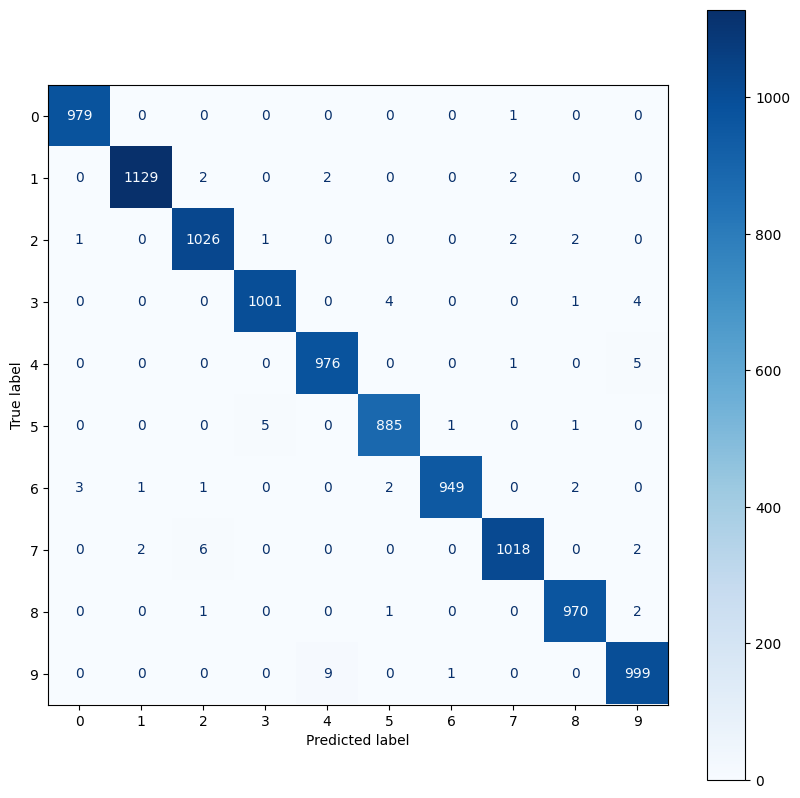

In [ ]:
plot_confusion_matrix(labels, pred_labels)

In [ ]:
corrects = torch.eq(labels, pred_labels)

In [ ]:
incorrect_examples = []

for image, label, prob, correct in zip(images, labels, probs, corrects):
    if not correct:
        incorrect_examples.append((image, label, prob))

incorrect_examples.sort(reverse=True,
                        key=lambda x: torch.max(x[2], dim=0).values)

In [ ]:
def plot_most_incorrect(incorrect, n_images):

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize=(20, 10))
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        image, true_label, probs = incorrect[i]
        true_prob = probs[true_label]
        incorrect_prob, incorrect_label = torch.max(probs, dim=0)
        ax.imshow(image.view(28, 28).cpu().numpy(), cmap='bone')
        ax.set_title(f'true label: {true_label} ({true_prob:.3f})\n'
                     f'pred label: {incorrect_label} ({incorrect_prob:.3f})')
        ax.axis('off')
    fig.subplots_adjust(hspace=0.5)

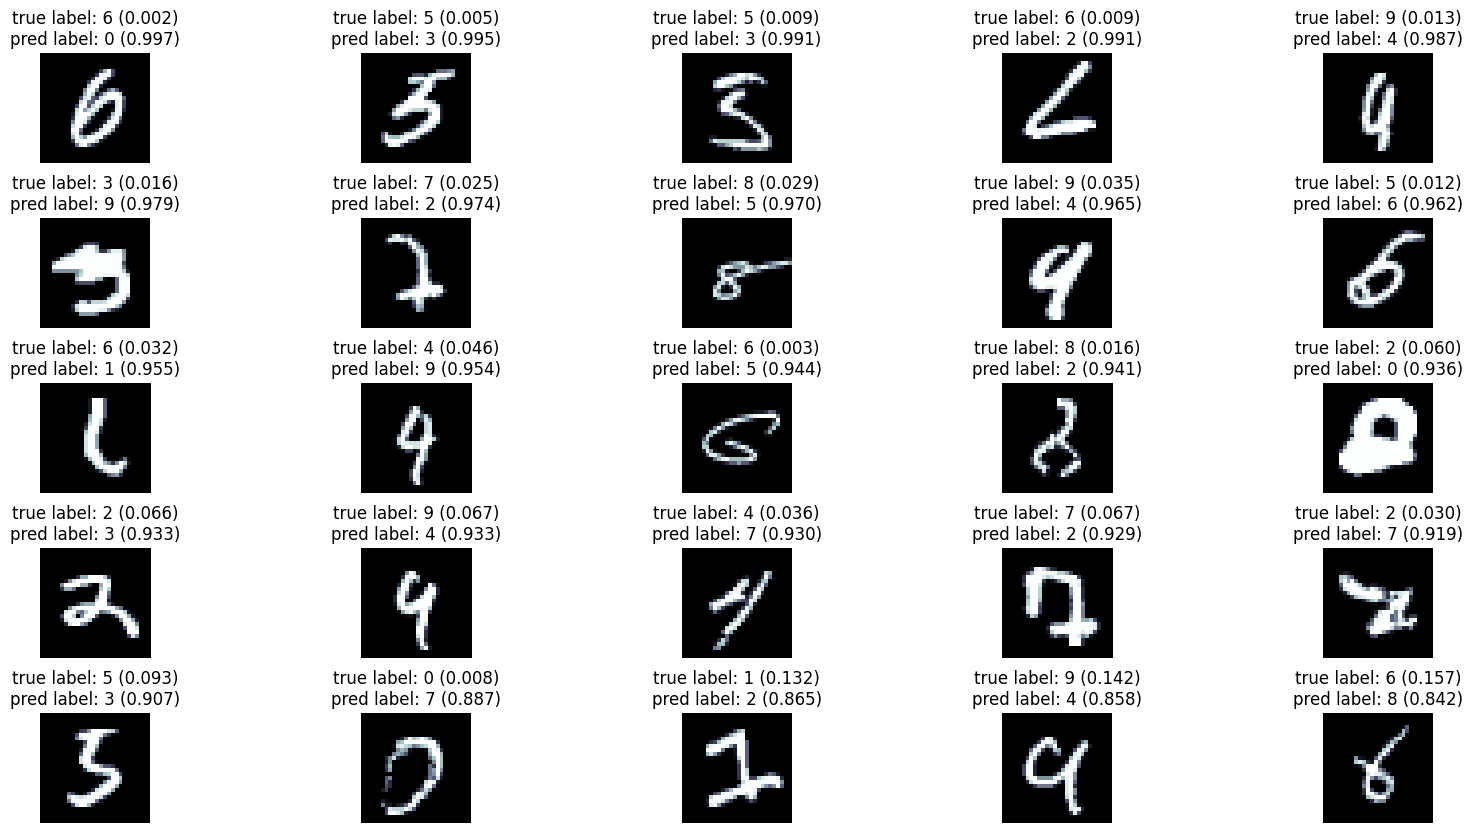

In [ ]:
N_IMAGES = 25

plot_most_incorrect(incorrect_examples, N_IMAGES)

In [ ]:
def get_representations(model, iterator, device):

    model.eval()

    outputs = []
    intermediates = []
    labels = []

    with torch.no_grad():

        for (x, y) in tqdm(iterator):

            x = x.to(device)

            y_pred, h = model(x)

            outputs.append(y_pred.cpu())
            intermediates.append(h.cpu())
            labels.append(y)

    outputs = torch.cat(outputs, dim=0)
    intermediates = torch.cat(intermediates, dim=0)
    labels = torch.cat(labels, dim=0)

    return outputs, intermediates, labels

In [ ]:
outputs, intermediates, labels = get_representations(model,
                                                     train_iterator,
                                                     device)

  0%|          | 0/844 [00:00<?, ?it/s]

In [ ]:
def get_pca(data, n_components=2):
    pca = decomposition.PCA()
    pca.n_components = n_components
    pca_data = pca.fit_transform(data)
    return pca_data

In [ ]:
def plot_representations(data, labels, n_images=None):
    if n_images is not None:
        data = data[:n_images]
        labels = labels[:n_images]
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    scatter = ax.scatter(data[:, 0], data[:, 1], c=labels, cmap='tab10')
    handles, labels = scatter.legend_elements()
    ax.legend(handles=handles, labels=labels)

In [ ]:
output_pca_data = get_pca(outputs)

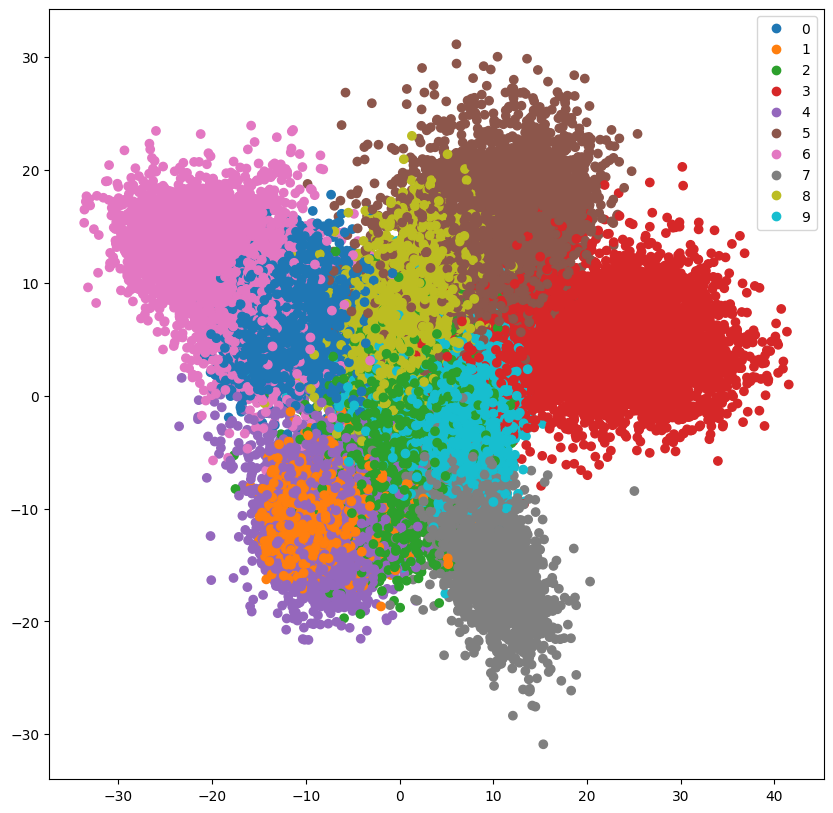

In [ ]:
plot_representations(output_pca_data, labels)

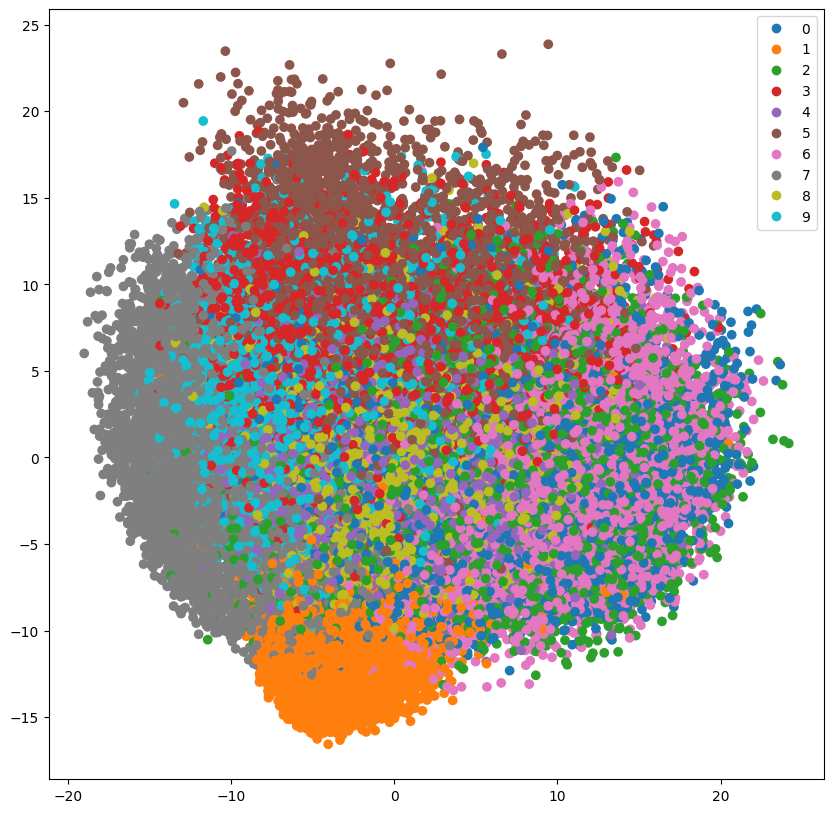

In [ ]:
intermediate_pca_data = get_pca(intermediates)
plot_representations(intermediate_pca_data, labels)

In [ ]:
def get_tsne(data, n_components=2, n_images=None):
    if n_images is not None:
        data = data[:n_images]
    tsne = manifold.TSNE(n_components=n_components, random_state=0)
    tsne_data = tsne.fit_transform(data)
    return tsne_data

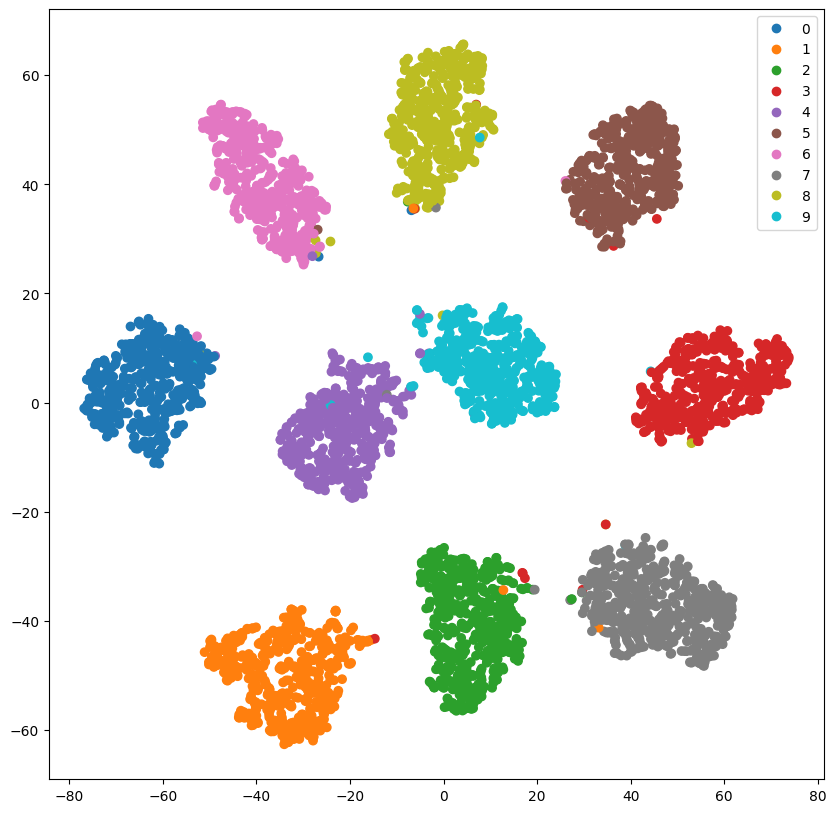

In [ ]:
N_IMAGES = 5_000

output_tsne_data = get_tsne(outputs, n_images=N_IMAGES)
plot_representations(output_tsne_data, labels, n_images=N_IMAGES)

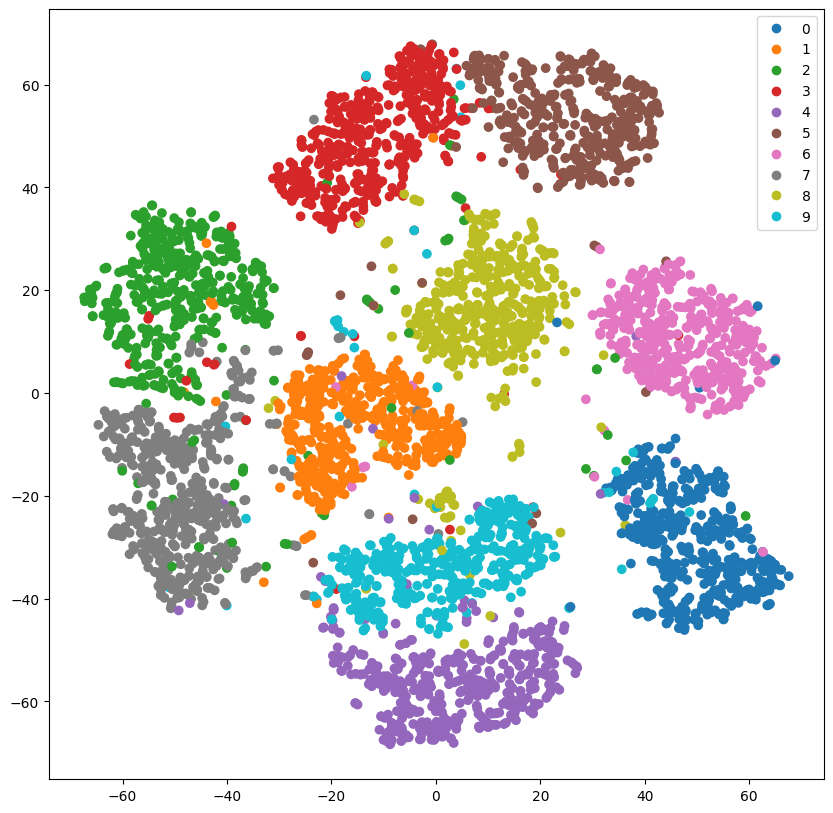

In [ ]:
intermediate_tsne_data = get_tsne(intermediates, n_images=N_IMAGES)
plot_representations(intermediate_tsne_data, labels, n_images=N_IMAGES)

In [ ]:
def imagine_digit(model, digit, device, n_iterations=50_000):

    model.eval()

    best_prob = 0
    best_image = None

    with torch.no_grad():

        for _ in trange(n_iterations):

            x = torch.randn(32, 1, 28, 28).to(device)

            y_pred, _ = model(x)

            preds = F.softmax(y_pred, dim=-1)

            _best_prob, index = torch.max(preds[:, digit], dim=0)

            if _best_prob > best_prob:
                best_prob = _best_prob
                best_image = x[index]

    return best_image, best_prob

In [ ]:
DIGIT = 3

best_image, best_prob = imagine_digit(model, DIGIT, device)

  0%|          | 0/50000 [00:00<?, ?it/s]

In [ ]:
print(f'Best image probability: {best_prob.item()*100:.2f}%')

Best image probability: 99.02%


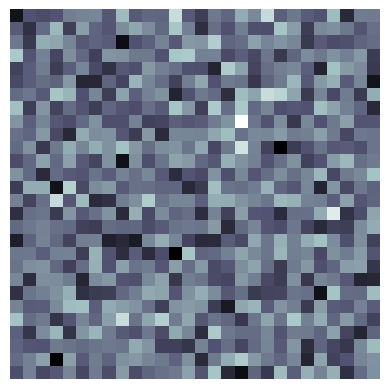

In [ ]:
plt.imshow(best_image.squeeze(0).cpu().numpy(), cmap='bone')
plt.axis('off');

In [ ]:
def plot_filtered_images(images, filters):

    images = torch.cat([i.unsqueeze(0) for i in images], dim=0).cpu()
    filters = filters.cpu()

    n_images = images.shape[0]
    n_filters = filters.shape[0]

    filtered_images = F.conv2d(images, filters)

    fig = plt.figure(figsize=(20, 10))

    for i in range(n_images):

        ax = fig.add_subplot(n_images, n_filters+1, i+1+(i*n_filters))
        ax.imshow(images[i].squeeze(0), cmap='bone')
        ax.set_title('Original')
        ax.axis('off')

        for j in range(n_filters):
            image = filtered_images[i][j]
            ax = fig.add_subplot(n_images, n_filters+1, i+1+(i*n_filters)+j+1)
            ax.imshow(image.numpy(), cmap='bone')
            ax.set_title(f'Filter {j+1}')
            ax.axis('off')

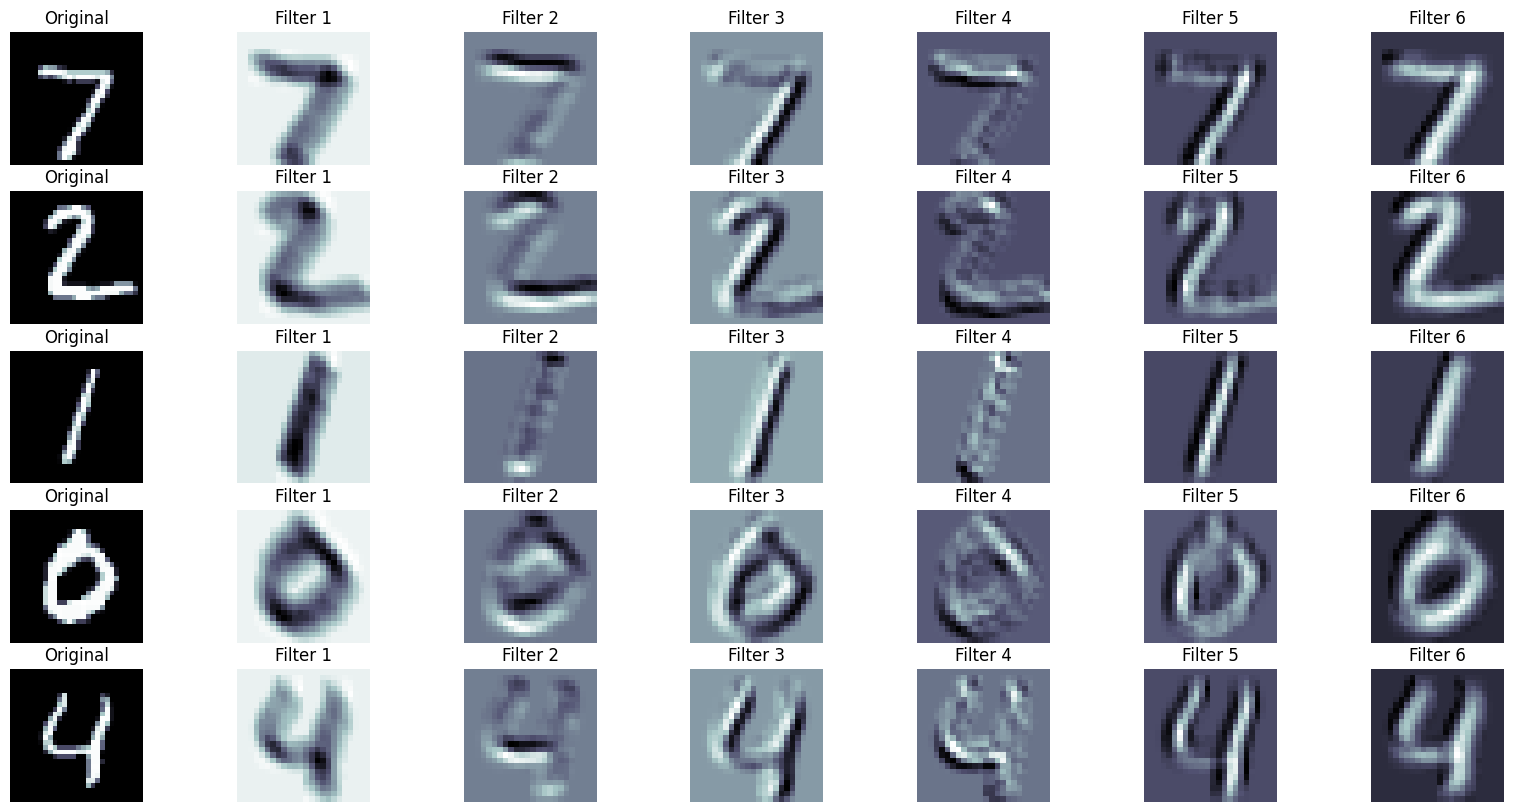

In [ ]:
N_IMAGES = 5

images = [image for image, label in [test_data[i] for i in range(N_IMAGES)]]
filters = model.conv1.weight.data

plot_filtered_images(images, filters)

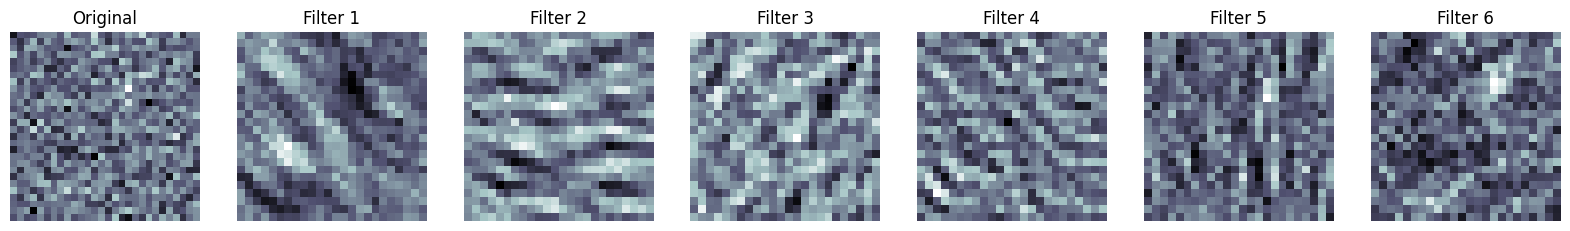

In [ ]:
plot_filtered_images([best_image], filters)

In [ ]:
def plot_filters(filters):

    filters = filters.cpu()

    n_filters = filters.shape[0]

    fig = plt.figure(figsize=(20, 10))

    for i in range(n_filters):

        ax = fig.add_subplot(1, n_filters, i+1)
        ax.imshow(filters[i].squeeze(0), cmap='bone')
        ax.axis('off')

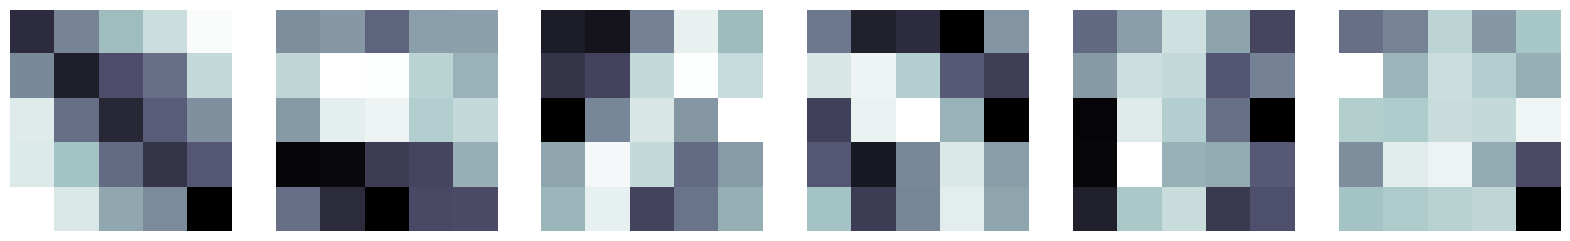

In [ ]:
plot_filters(filters)